## Cell 1:

# Cell 1

### 15 October 2021
### K. M. Jones (kmj.jones@gmail.com)
This quick notebook takes in fully processed, registered, trimmed, and re-convolved astronomical images
and runs them through Source Extractor's dual image mode
using settings that were selected to best handle the data from GoGreen clusters of galaxies (described, and set, in default_dualimage.sex)
and produces an output Fits file holding a combined table of data from both the red and blue images
identified using the positions determined from the redder of the two images

It then adds two columns containing information from the weight images associated with
both the red and the blue (reprojected) image (the reprojected blue weight image)
hmmm shoot do I need to convolve that blue weight image too?? 

**GHR: 5.Apr.2022** I don't think that we need to convolve the blue weight image.  Officially it's the right thing to do but in practice makes almost no difference

next, it adds two columns of information that give the noise dispersion for the 
flux_aper measurements made in red and blue

**WES: 17.Apr.2022** The parts of the code that need changed from cluster to cluster are marked with the string"#@@@"

## Cell 2:

In [1]:
#Cell 2
from astropy.io import fits
from astropy.table import Table#helps read sexfiles
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import getweight
from astropy import wcs
import depthcalc
import scipy as sp
import math as m
from io import StringIO
from IPython.display import clear_output #cell 3 has an output longer than *insert whitty idiom*
from importlib import reload #helps not have to reload entire notebook to test one change
from astropy.io import ascii

## Cell 3:

In [2]:
#clear output after finished?
clear = True

#Cell 3
#update this to have user input filered, fileblue, and output catalog names
#change these
#@@@
filered="/home/wes/Astronomy/Data/GoGreen/j020548m5829/PreData/j020548m5829-f140w_drz_sci.fits"
fileblue="/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/j0205_f606w_reprj_conv_sept21b_7.fits"

#this contains a lot of info about each cluster.  
metatab="/home/wes/Astronomy/Code/catalog_creation/metatable_v1.txt"

red_hdu=fits.open(filered)
blue_hdu=fits.open(fileblue)
rhdr=red_hdu[0].header
bhdr=blue_hdu[0].header

#these are values needed to convert the flux in the image into magnitudes.  
#The necessary conversion comes from the HST data manual (or handbook, can't remember the name)
photvals=[rhdr['PHOTFLAM'],rhdr['PHOTPLAM']]
photvalsb=[bhdr['PHOTFLAM'],bhdr['PHOTPLAM']]

#things KMJ wrote as stuff she'd like to do
#will need an output objectsubtracted or seg image to calculate the rms?
#hmm, maybe to use the pre-dual-mode images to calc rms bc more accurate (more area, def) for ie blue

#output catalog names
#@@@
fileoutrr='j0205_dualrr_cbs_min5.cat'
fileoutrb='j0205_dualrb_cbs_min5.cat'

#WS: change these for each cluster
#WES: moved these higher for use in os.system
#@@@
redwht="/home/wes/Astronomy/Data/GoGreen/j020548m5829/PreData/j020548m5829-f140w_drz_wht.fits"
bluewht="/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/j0205_f606w_reprj_wht.fits"

#GHR will need to put in explicit path names for all input and output files
#this runs SExtractor with a set of input parameters that override those in the .sex file
#WES noticed a WEIGHT_IMAGE setting in the default_dualimage.sex
#@@@ -c checkfile name
#this runs command line sextractor
#inputs are 2 images, .sex file, output name, wht file
wb=os.system("sex" + " " + filered + "," + filered + " -c default_dualimage.sex -CATALOG_NAME" + " " + fileoutrr + " -WEIGHT_IMAGE " + redwht + " -CHECKIMAGE_NAME j0205_rr_seg.fits" )  
wr=os.system("sex" + " " + filered + "," + fileblue + " -c default_dualimage.sex -CATALOG_NAME" + " " + fileoutrb + " -WEIGHT_IMAGE " + redwht + " -CHECKIMAGE_NAME j0205_rb_seg.fits")

#GHR:not sure what these do, probably want to change them to take the information from the file name
colnames=['SE_ID_f140w','X_IMAGE_f140w','Y_IMAGE_f140w','ALPHA_J2000_f140w','DELTA_J2000_f140w','SEFLAGS_f140w','CLASS_STAR_f140w','FLUX_AUTO_f140w','FLUXERR_AUTO_f140w','FLUX_ISO_f140w','FLUXERR_ISO_f140w','FLUX_APER_f140w','FLUXERR_APER_f140w','FWHM_IMAGE_f140w','KRON_RADIUS_f140w','ISOAREA_IMAGE_f140w','A_IMAGE_f140w','B_IMAGE_f140w','THETA_IMAGE_f140w']
colnames2=['X_IMAGE_f606w','Y_IMAGE_f606w','ALPHA_J2000_f606w','DELTA_J2000_f606w','SEFLAGS_f606w','CLASS_STAR_f606w','FLUX_AUTO_f606w','FLUXERR_AUTO_f606w','FLUX_ISO_f606w','FLUXERR_ISO_f606w','FLUX_APER_f606w','FLUXERR_APER_f606w','FWHM_IMAGE_f606w','KRON_RADIUS_f606w','ISOAREA_IMAGE_f606w','A_IMAGE_f606w','B_IMAGE_f606w','THETA_IMAGE_f606w']
#WES:tracking down and renaming these colnames for my own sanity
#colnames=['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLAGS','CLASS_STAR','FLUX_AUTO','FLUXERR_AUTO','FLUX_ISO','FLUXERR_ISO','FLUX_APER','FLUXERR_APER','FWHM_IMAGE','KRON_RADIUS','ISOAREA_IMAGE','A_IMAGE','B_IMAGE','THETA_IMAGE']
#@@@
outputcatalog='catalog_dualmode_j020548m5829.fits'

#changed these to 140 aswell
#GHR it seems like these are not used anywhere so we can try to comment them out.
#rednames=['FLUX_AUTO_f140w','FLUX_ISO_f140w','FLUX_APER_f140w']
#bluenames=['FLUX_AUTO_f606w','FLUX_ISO_f606w','FLUX_APER_f606w']

#WES: gets rid of output
if clear:
    clear_output()

    



##  Cell 4:

In [3]:
#Cell 4
#WES: format is ascii.sextractor
#GHR: Read in output catalogs from SExtractor.  Each of these contains the fluxe measured on one of the
#images as detected on the red image
f=open(fileoutrr,'r')
rro= Table.read(fileoutrr, format='ascii.sextractor')#Red on Red Output
g=open(fileoutrb,'r')
rbo= Table.read(fileoutrb, format='ascii.sextractor')#Red on Blue Output
#typehold='f8,f8,f8,f8,i8,f8,f8,f8,f8,f8,f8,f8,f8,f8,i8,f8,f8,f8'

#print(rro)
for i in range(0,19):
    print(rro[0][i])

print(rro)
#GHR: reads in SExtractor output catlaogs but has a hardcoded number of output columns
datarr=np.genfromtxt(f,skip_header=19,comments='#',usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))

#GHR: skips first output column in blue file because it contains a duplicate ID.
datarb=np.genfromtxt(g,skip_header=19,comments='#',usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))

#row-based arrangement
#GHR: combaines two files on a row-by-row basis to form a combined file
#data
data_total=np.concatenate((datarr,datarb),axis=1)
#column names
nms=np.concatenate((colnames, colnames2),axis=0)
#GHR if you changed the above to use the SExtractor automatic read format from https://het.as.utexas.edu/HET/Software/Astropy-0.4.2/io/unified.html 
# then the column names would be automatically generated and not have to be manually entered


#print(nms)

#print(np.shape(datarr),np.shape(datarb),np.shape(data_total))
#print(datarr[0,13],datarr[0,14])
#print(datarb[0,12],datarb[0,13])
#print(data_total[6,13],data_total[6,14])
#print(data_total[6,30],data_total[6,31])

1
3017.0647
2164.6582
31.4497661
-58.5174595
0
0.776
11.68701
8.391624
4.406504
2.749415
7.796967
6.62978
3.99
5.91
10
1.296
0.618
-49.77
NUMBER  X_IMAGE   Y_IMAGE  ALPHA_J2000 ... A_IMAGE B_IMAGE THETA_IMAGE
          pix       pix        deg     ...   pix     pix       deg    
------ --------- --------- ----------- ... ------- ------- -----------
     1 3017.0647 2164.6582  31.4497661 ...   1.296   0.618      -49.77
     2 2957.5374 2182.2493  31.4529322 ...   0.912   0.433       -0.36
     3 3042.2898 2251.3616  31.4484239 ...   1.656   1.446      -72.72
     4 2897.6177 2251.1328  31.4561184 ...   1.184   1.039       18.81
     5 2994.1917 2284.4846  31.4509817 ...   1.909   1.774      -48.83
     6 2919.8904 2293.0117  31.4549333 ...   7.044   2.098      -13.12
   ...       ...       ...         ... ...     ...     ...         ...
  1435 3228.2346 4210.3179  31.4385373 ...   1.261   0.905      -50.34
  1436 3007.1226 4218.6406  31.4502791 ...   1.492   1.306       18.28
  1437 326

## Cell 5:

In [4]:
#Cell 5
##### convert units for catalog output
#make units: uJy (for catalog; convert to magnitude when USE catalog to make plot
# OR Give f/f(m=25) as the catalog quantity,
#such that you can compute AB magnitude using m = -2.5 * log(f/f(m=25)) + 25
#note that FLUXAPER and FLUXAUTO and etc that result from 
#source extractor should be in *counts*, so need to be converted to Jy first.

#print('red auto iso aper:',np.where(nms=='FLUX_AUTO_f105w'),np.where(nms=='FLUX_ISO_f105w'),np.where(nms=='FLUX_APER_f105w'))
#print('blue auto iso aper:',np.where(nms=='FLUX_AUTO_f606w'),np.where(nms=='FLUX_ISO_f606w'),np.where(nms=='FLUX_APER_f606w'))


#GHR: these are values specific to each image and come from the image header earlier  in the code
photflam_red=photvals[0]
photflam_blue=photvalsb[0]
photplam_red=photvals[1]
photplam_blue=photvalsb[1]

#GHR these are equations from the HST data handbook
c_ang=sp.constants.c * (10.0**10.0)
conversion=((photplam_red*photplam_red)/c_ang)*(1.0/(10.0**(-23.0)))*(10.0**6.0)
convb=((photplam_blue*photplam_blue)/c_ang)*(1.0/(10.0**(-23.0)))*(10.0**6.0)

#GHR: takes the column in the data_total array corresponding to the column name in 'nms' and assigns it 
#to a named variable.  It would be a better practice to assign these to new Table columns instead of making
#new variables for every column
#GHR: The 105 and 140 need to be made consistent throughout.  
#countsauto_f140w=data_total[:,int(np.where(nms=='FLUX_AUTO_f140w')[0])] #from lines 8 and 9 in this cell
countsauto_f140w=rro['FLUX_AUTO']
#print("coutsauto")
#print(countsauto_f140w)
#print("table")
#print(rro['FLUX_AUTO'])

#cerr_auto_f105w=data_total[:,int(np.where(nms=='FLUXERR_AUTO_f105w')[0])]
#countsiso_f140w=data_total[:,int(np.where(nms=='FLUX_ISO_f140w')[0])]
countsiso_f140w=rro['FLUX_ISO']
#cerr_iso_f105w=data_total[:,int(np.where(nms=='FLUXERR_ISO_f105w')[0])]
#countsaper_f140w=data_total[:,int(np.where(nms=='FLUX_APER_f140w')[0])]
countsaper_f140w=rro['FLUX_APER']
#cerr_aper_f105w=data_total[:,int(np.where(nms=='FLUXERR_APER_f105w')[0])]
#countsauto_f606w=data_total[:,int(np.where(nms=='FLUX_AUTO_f606w')[0])]
countsauto_f606w=rbo['FLUX_AUTO']
#cerr_auto_f606w=data_total[:,int(np.where(nms=='FLUXERR_AUTO_f606w')[0])]
#countsiso_f606w=data_total[:,int(np.where(nms=='FLUX_ISO_f606w')[0])]
countsiso_f606w=rbo['FLUX_ISO']
#cerr_iso_f606w=data_total[:,int(np.where(nms=='FLUXERR_ISO_f606w')[0])]
#countsaper_f606w=data_total[:,int(np.where(nms=='FLUX_APER_f606w')[0])]
countsaper_f606w=rbo['FLUX_APER']
#cerr_aper_f606w=data_total[:,int(np.where(nms=='FLUXERR_APER_f606w')[0])]

#GHR: applies coversion values from HST handbook to generate fluxes in microJy for each flux
#This is done for the AUTO, ISO, and Circular aperture
#recall f_nu= pivot lambda^2/c * flambda?  #GHR not sure why there is a '?'
#GHR F105W
flambda_auto_f140w=countsauto_f140w*photflam_red
fnu_auto_f140w = flambda_auto_f140w*conversion #now in microJansky
flambda_iso_f140w=countsiso_f140w*photflam_red
fnu_iso_f140w = flambda_iso_f140w*conversion #now in microJansky
flambda_aper_f140w=countsaper_f140w*photflam_red
fnu_aper_f140w = flambda_aper_f140w*conversion #now in microJansky

#GHR: F606W
flam_auto_606=countsauto_f606w*photflam_blue
fnu_auto_f606w=flam_auto_606*convb #now in microJansky
flam_iso_f606w=countsiso_f606w*photflam_blue
fnu_iso_f606w=flam_iso_f606w*convb
flam_aper_f606w=countsaper_f606w*photflam_blue
fnu_aper_f606w=flam_aper_f606w*convb



## Cell 6:

In [5]:
#Cell 6 
#WES:this cell takes a long time to run ~ 1 min
##Pull the weight value from the corresponding(ish) pixel for each band's wht.fits


#oh, crap, x_image and y_image aren't integers -.-
#round them to the nearest integer and then subtract 1 from each to feed 
#into the array that wi gives (a regular ol array starts at 0,0)

#above is the weight image, reprojected (blue2red_exactfinal)
#uhhhhhhh should I convolve it too? IDK why, that should only concern the spread of flux, not weight

wi_f140w=[]
wi_f606w=[]

#GHR: for every single catalog entry (or object) find the pixels of the center of that object
#go to the corresponding pixel in the weight image, and save that value.
for i in range(len(rro['NUMBER'])):
    #GHR get x and y pixel for every source.  Round them to integer values.  There is an 
    #indexing problem here because x,y in SExtractor start from 1 and arrays start from 0.  
    #This is actually taken care of in getweight.wi
    #1 and 2 index refer to 1st and 2nd column
    #of catalog, which are the x and y coordinate.  This will break if the column output order
    #is changed.
    #wix=round(data_total[i,1])
    #wiy=round(data_total[i,2])
    wix=round(rro['X_IMAGE'][i])
    wiy=round(rro['Y_IMAGE'][i])
    
    #get weight image in the two images for every source and append it to the total list
    wir=getweight.wi(redwht,wix,wiy)
    #if(wir>0):
        #wi_f140w.append(wir)
    wi_f140w.append(wir)
    
for i in range(len(rbo['NUMBER'])):
    #GHR get x and y pixel for every source.  Round them to integer values.  There is an 
    #indexing problem here because x,y in SExtractor start from 1 and arrays start from 0.  
    #This is actually taken care of in getweight.wi
    #1 and 2 index refer to 1st and 2nd column
    #of catalog, which are the x and y coordinate.  This will break if the column output order
    #is changed.
    #wix=round(data_total[i,1])
    #wiy=round(data_total[i,2])
    wix=round(rbo['X_IMAGE'][i])
    wiy=round(rbo['Y_IMAGE'][i])
    
    #get weight image in the two images for every source and append it to the total list
    wib=getweight.wi(bluewht,wix,wiy)
    #if(wib>0):
        #wi_f606w.append(wib)
    wi_f606w.append(wib)

#GHR get the maximum value of the weight image over all pixels for each image
#based on the getweight.getmax code, the first value returned is actually the top 1%, not 10%
wr10pct,wrmax=getweight.getmax(redwht)
wb10pct,wbmax=getweight.getmax(bluewht)
print(wr10pct,wb10pct)
#output these to meta-table? or just use em myself

#add wi columns
#GHR turn list into array and then normalize array by 1% highest value
#F105W
wif140w=np.array(wi_f140w)
wir_wimx=wif140w/wr10pct   #normalizes by 1% highest value, not 10% highest value as name indicates
#GHR I'm not sure why this is being reshaped (never was good at reshaping) but the number of rows 
#is hardcoded.  This needs to be determined by the number of sources in your catalog, basically 
#len(data_total[:,1])
#wi_red=wir_wimx.reshape((len(rro['NUMBER']),1))

#F606W
wif606w=np.array(wi_f606w)
wib_wimx=wif606w/wb10pct
#wi_blue=wib_wimx.reshape((len(rbo['NUMBER']),1))


#####a little check demonstrating why we want wb10pct instead of wbmax
####don't need to run this
#wr10pct,wrmax=getweight.getmax(redwht)
#wb10pct,wbmax=getweight.getmax(bluewht)
#print('10percent from the top red, highestred, then same for blue,blue',wr10pct,wrmax)
#print(wb10pct,wbmax)
#plt.plot(wif606w,'g.') shows why we want wb10pct instead of wbmax



24408.932 48989.18137629229


## Cell 6.5:

In [6]:
#cell 6.5
###this is an in-progress cell trying to extract the necessary 
#rms and C1, C2 values below from the metatable rather than entering them manually
#replacing the #********* bracketed section in Cell 7 below.

#WES: mt = metatable
#mt=np.loadtxt(metatab,dtype=str,delimiter='\t',usecols=22,comments='#')
#print(mt)

#WES: imports the metatable as strings so be sure to use float() to turn them back into numbers
mt=np.genfromtxt(metatab,delimiter='\t',comments='#',dtype=str,usecols=(range(0,23)))
#print(mt)
#@@@
myMt=mt[4]#this reads in the specific row from the metatable, this needs redone
print(myMt)#WES: not sure how to get around hard coding this, 
#or if getting around it is even worth my time because this whole file
#is supposed to be cluster specfic

#print(myMt[22]) #=red c2
#print(myMt[15])# =blue identifier
#print(myMt[17])# =blue c1

#t=open(metatab,'r')
#contents=t.read()
#tmp={"names":['col1','col2'],"formats":['string','f8']}
#tmp2=[('A',str),('C',float)]
#mettmp=np.genfromtxt(t,comments='#',dtype=tmp2,usecols=(0,2))
#print(mettmp)
#holdformat={"names":['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W'],"formats":['str','str',f6,f6,f4,'f6','f6','f6','f6','f6','f3','f3','f3','f3','f3','str','f8','f8','f8','str','f8','f8','f8']}
#print(holdformat["formats"])
#meta_table=np.genfromtxt(t,dtype=holdformat,comments='#',usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23))
#print(meta_table)

["'SPT 0205'" 'j020548m5829' '31.4437' '-58.4855' '1.320' '9492' '3728'
 '24694.75492' '25226.69323' '11651.04421' '27.8' '0' '27.9' '28.3' '27.7'
 'F606w' '0.008438031' '0.01086983571' '0.0002707492528' 'F140w'
 '0.017499708' '0.01168819508' '0.001163945998']


## Cell 7:

In [8]:
#Cell 7
### make/calculate/construct new errrors for flux auto1 and flux auto2
#disp_i(N) = N*o_bar(a_i + (b_i * N))/np.sqrt(wi)
#need: N, linear size = sqrt(area) ~radius. aperture is 5.0 pixels diameter so 2.5 pix radius
#o_bar (rms for the image/band),
#ai and bi (coefficients of the parameterized function for the image/band)
#weight value (wi, not wi/wimax)
denomr=np.sqrt(wif140w)
denomb=np.sqrt(wif606w)

print(denomr)
print(denomb)


#kr_red = data_total[:,int(np.where(nms=='KRON_RADIUS_f140w')[0])]#this isn't radius yet
kr_red = rro['KRON_RADIUS']
print(len(rro['KRON_RADIUS']))
#a_red=data_total[:,int(np.where(nms=='A_IMAGE_f140w')[0])]
a_red=rro['A_IMAGE']
#b_red=data_total[:,int(np.where(nms=='B_IMAGE_f140w')[0])]
b_red=rro['B_IMAGE']
N_AUTOred=np.sqrt(m.pi*(a_red*kr_red)*(b_red*kr_red))
#kr_blue = data_total[:,int(np.where(nms=='KRON_RADIUS_f606w')[0])]
#a_blue=data_total[:,int(np.where(nms=='A_IMAGE_f606w')[0])]
#b_blue=data_total[:,int(np.where(nms=='B_IMAGE_f606w')[0])]
kr_blue=rbo['KRON_RADIUS']
print(len(rbo['KRON_RADIUS']))
a_blue=rbo['A_IMAGE']
b_blue=rbo['B_IMAGE']
N_AUTOblue= np.sqrt(m.pi*(a_blue*kr_blue)*(b_blue*kr_blue))

Naper = 2.5  #aperture is 5.0 pixels diameter so 2.5 pix radius . NOTE THIS IS N_APER; same for red and blue
N_ISO1red = rro['ISOAREA_IMAGE']#this should = sqrt of ISO_AREA
N_ISO_f140w=np.sqrt(N_ISO1red)
N_ISO1blue = rbo['ISOAREA_IMAGE']
N_ISO_f606w=np.sqrt(N_ISO1blue)

reload(depthcalc)#reloads depthcalc if I am making changes to that file
#well, I should read this out of the meta-table that I haven't created yet
#*******************
#specific to individual bands and clusters (each image)
#C1 and C2 come from fitting in Working_Depth.ipynb
#@@@
fileredmask='/home/wes/Astronomy/Code/catalog_creation/HSTdata/j020548m5829-f140w_drz_sci_mask.fits'
fileredseg='/home/wes/Astronomy/Code/catalog_creation/source_extractor/j0205_rr_seg.fits'
obar_counts_f140w,useless=depthcalc.rmscalc(filered,fileredmask,fileredseg,[5,10]) #(note that these are just some random values in the array bc it requires it to be input to make the second output; but we don't care about the second output so basically ignore. later on I should set it up to be default turned off or something)
obar_f140w=obar_counts_f140w*photflam_red*conversion
C1_f140w=float(myMt[21])
a_f140w=C1_f140w/obar_f140w
C2_f140w=float(myMt[22])
b_f140w=C2_f140w/obar_f140w

#@@@
#WES: strange errors from using the blue wht file, I think the point is just to ignore the space with no data so red wht should work
#WES: KMJ used j2106_blue2red_exact_conv_apr21_5_mask.fits' so I think we just need to repoject the wht file
#filebluemask='/home/wes/Astronomy/Data/GoGreen/j020548m5829/PreData/j020548m5829-f606w_drc_wht.fits'
filebluemask='/home/wes/Astronomy/Code/catalog_creation/HSTdata/j0205_f606w_reprj_conv_sept21b_7_mask.fits'
fileblueseg='/home/wes/Astronomy/Code/catalog_creation/source_extractor/j0205_rb_seg.fits'
obar_counts_f606w,useless=depthcalc.rmscalc(fileblue,filebluemask,fileblueseg,[5,10])
obar_f606w=obar_counts_f606w*photflam_blue*convb
C1_f606w=float(myMt[17])
a_f606w=C1_f606w/obar_f606w
C2_f606w=float(myMt[18]) ###these coefficients are unitless btw
b_f606w=C2_f606w/obar_f606w
#**********************

#fluxerrs in counts
fluxerr_aper_f140w=(C1_f140w*Naper + C2_f140w*Naper*Naper)/denomr
fluxerr_auto_f140w=(C1_f140w*N_AUTOred + C2_f140w*N_AUTOred*N_AUTOred)/denomr
fluxerr_iso_f140w=(C1_f140w*N_ISO_f140w + C2_f140w*N_ISO_f140w*N_ISO_f140w)/denomr
print(len(denomb))
fluxerr_aper_f606w=(C1_f606w*Naper + C2_f606w*Naper*Naper)/denomb
fluxerr_auto_f606w=(C1_f606w*N_AUTOblue + C2_f606w*N_AUTOblue*N_AUTOblue)/denomb
fluxerr_iso_f606w=(C1_f606w*N_ISO_f606w + C2_f606w*N_ISO_f606w*N_ISO_f606w)/denomb

#convert to fluxes; ratios of s/n (or n/s, whatev) in counts and in flux should be the same, so scale:
delff_140w = fluxerr_aper_f140w/countsaper_f140w
fluxerr_aper_jy_f140w = delff_140w*fnu_aper_f140w
delff_auto_red = fluxerr_auto_f140w/countsauto_f140w
fluxerr_auto_jy_f140w = delff_auto_red*fnu_auto_f140w
delff_iso_red = fluxerr_iso_f140w/countsiso_f140w
fluxerr_iso_jy_f140w = delff_iso_red*fnu_iso_f140w

delff_606w=fluxerr_aper_f606w/countsaper_f606w
fluxerr_aper_jy_f606w=delff_606w*fnu_aper_f606w
delff_auto_blue=fluxerr_auto_f606w/countsauto_f606w
fluxerr_auto_jy_f606w=delff_auto_blue*fnu_auto_f606w
delff_iso_blue=fluxerr_iso_f606w/countsiso_f606w
fluxerr_iso_jy_f606w=delff_iso_blue*fnu_iso_f606w

#print(np.shape(fluxerr_auto_jy_f606w[np.isnan(fluxerr_auto_jy_f606w)]))
#hmm, a few NaNs preserved

#####just checking on the flux conversion for the errors and the fluxes
####don't need this chunk to do anything.
#fea105w_jy=fluxerr_aper_f105w*photflam_red*conversion
#fea606w_jy=fluxerr_aper_f606w*photflam_blue
#delf_f_ratio=fluxerr_aper_f105w/countsaper_f105w
#delf_f_rat_jy=fea105w_jy/fnu_aper_f105w
#ratio2=delf_f_rat_jy/delf_f_ratio
#print(np.shape(ratio2))
#print(np.shape(ratio2[np.where(ratio2>0.99999985)]))
#print(np.shape(ratio2[np.isnan(ratio2)]))
#ah, yep, the two ratios, in counts and janskies, are virtually identical (at far less than ~ few % level)
#so either method works.


[0. 0. 0. ... 0. 0. 0.]
[169.91138647 185.39694236 184.35009101 ...   0.           0.
   0.        ]
1441
1441
(array([2162, 2162, 2163, ..., 4236, 4237, 4237]), array([3017, 3018, 3015, ..., 3326, 3325, 3326]))
STDEV of all "valid" pixels in scidata: 15.514541
rms actual: 15.521591
(array([2162, 2162, 2163, ..., 4236, 4237, 4237]), array([3017, 3018, 3015, ..., 3326, 3325, 3326]))
STDEV of all "valid" pixels in scidata: 0.7262750423216211
rms actual: 0.7267339691338834
1441


/tmp/ipykernel_6782/3660066671.py:68: RuntimeWarning: divide by zero encountered in true_divide
  fluxerr_aper_f140w=(C1_f140w*Naper + C2_f140w*Naper*Naper)/denomr
/tmp/ipykernel_6782/3660066671.py:69: RuntimeWarning: divide by zero encountered in true_divide
  fluxerr_auto_f140w=(C1_f140w*N_AUTOred + C2_f140w*N_AUTOred*N_AUTOred)/denomr
/tmp/ipykernel_6782/3660066671.py:70: RuntimeWarning: divide by zero encountered in true_divide
  fluxerr_iso_f140w=(C1_f140w*N_ISO_f140w + C2_f140w*N_ISO_f140w*N_ISO_f140w)/denomr
/tmp/ipykernel_6782/3660066671.py:72: RuntimeWarning: divide by zero encountered in true_divide
  fluxerr_aper_f606w=(C1_f606w*Naper + C2_f606w*Naper*Naper)/denomb
/tmp/ipykernel_6782/3660066671.py:73: RuntimeWarning: divide by zero encountered in true_divide
  fluxerr_auto_f606w=(C1_f606w*N_AUTOblue + C2_f606w*N_AUTOblue*N_AUTOblue)/denomb
/tmp/ipykernel_6782/3660066671.py:73: RuntimeWarning: invalid value encountered in true_divide
  fluxerr_auto_f606w=(C1_f606w*N_AUTOblue

## Cell 8:

In [9]:
#Cell 8

#turn output data into a fits table

#WES:change these names to represent units.
#WES:these are in microjanskys
data_total1=data_total.copy()
rro['FLUX_AUTO_MJ'] = fnu_auto_f140w[:]
rro['FLUXERR_AUTO'] = fluxerr_auto_jy_f140w[:]
rro['FLUX_ISO_MJ'] = fnu_iso_f140w[:]
rro['FLUXERR_ISO'] = fluxerr_iso_jy_f140w[:]
rro['FLUX_APER_MJ'] = fnu_aper_f140w[:]
rro['FLUXERR_APER'] = fluxerr_aper_jy_f140w[:]
rbo['FLUX_AUTO_MJ'] = fnu_auto_f606w[:]
rbo['FLUXERR_AUTO'] = fluxerr_auto_jy_f606w[:]
rbo['FLUX_ISO_MJ'] = fnu_iso_f606w[:]
rbo['FLUXERR_ISO'] = fluxerr_iso_jy_f606w[:]
rbo['FLUX_APER_MJ'] = fnu_aper_f606w[:]
rbo['FLUXERR_APER'] = fluxerr_aper_jy_f606w[:]

#hdr=fits.PrimaryHDU(rro)
#hdb=fits.PrimaryHDU(rbo)
#hdr.writeto('red'+outputcatalog)
#hdb.writeto('blue'+outputcatalog)

rro.write('j0205red.fits', overwrite=True)
rbo.write('j0205blue.fits', overwrite=True)
#WES: note store these in a drive or dropbox
#WES: note clean the files out of github

#data_total2=np.concatenate((data_total1,FLUXERR_APER_F105w,FLUXERR_APER_F606w),axis=1)
#data_total2=np.concatenate((data_total1,wi_red,wi_blue),axis=1)
#print(np.shape(data_total1),np.shape(data_total2))

#coltot=np.concatenate((colnames,colnames2,['F105w_normweight'],['F606w_normweight']),axis=0)
#k=0
#n=[]
#for item in coltot:
#    a=fits.Column(name=item,array=data_total2[:,k],format='f8')
#    n.append(a)
#    k+=1

#t=fits.BinTableHDU.from_columns(n)
#t.writeto(outputcatalog)



In [10]:
hdulist = fits.open('test.fits') 
test = Table.read(hdulist[1])
test2 = Table.read(hdulist)
#test=ascii.read('test.fits')
#print(test)
#print(test2)
for i in test[0]:
    print(i)


1
3017.0647
2164.6582
31.4497661
-58.5174595
0
0.776
1.1136686700176441
inf
0.4199008513817845
inf
0.7429819833354692
inf
3.99
5.91
10
1.296
0.618
-49.77


-hmm, not sure why there are a few points in the weight image with bizarre weight values (extra high), but clearly this is gonna lead to wi/wmax that are greater than 1
-so, probably need to flag anything with the column >1, for both wib_wimx and wir_wimx


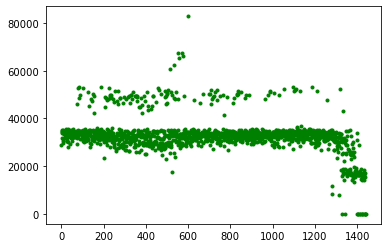

In [11]:
#a bonus cell demonstrating why we want the upper limit of the weight value to be not the highest value but the 10% highest value
plt.plot(wif606w,'g.')
print('-hmm, not sure why there are a few points in the weight image with bizarre weight values (extra high), but clearly this is gonna lead to wi/wmax that are greater than 1')
print('-so, probably need to flag anything with the column >1, for both wib_wimx and wir_wimx')

In [12]:
#write out all of source extractors outputs into the catalog

#remove weights < 0.2 and flags non zero